In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import pickle



In [32]:
df = pd.read_parquet("../data/processed/ENEFIT_dataset.parquet")
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.weekday + 1
df['target_production'] = df['installed_capacity'] * df['direct_solar_radiation'] / (df['temperature'] + 273.15)
df["capacity_per_eic"] = np.round(df["installed_capacity"] / df["eic_count"], 2)
df['Weekday'] = [0 if day > 4 else 1 for day in df.index.dayofweek]
df['Weekday'] = df['Weekday'].astype('int64')  # Explicitly cast to int64


In [33]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):
              final_predictions[i, 0] = org_X_train[i,-1] + pred[i,0]
              for j in range(1, pred.shape[1]):
                     final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
       return final_predictions

In [34]:

n_past = 24
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)
org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)


In [35]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

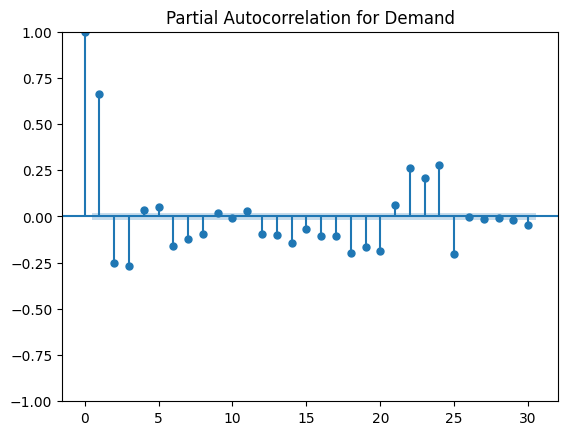

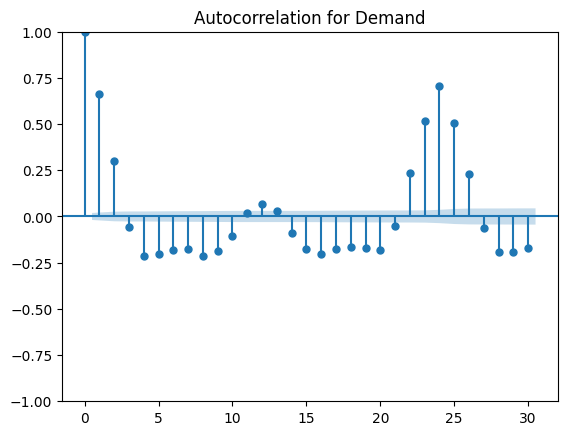

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PACF for p
plot_pacf(train_df[target_column_name], lags=30)
plt.title("Partial Autocorrelation for Demand")
plt.show()

# ACF for q
plot_acf(train_df[target_column_name], lags=30)
plt.title("Autocorrelation for Demand")
plt.show()


In [37]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=30, max_q=30, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

#6,0,5

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10661
Model:              SARIMAX(25, 0, 1)   Log Likelihood              -89837.266
Date:                Sat, 23 Mar 2024   AIC                         179728.531
Time:                        02:30:28   BIC                         179924.939
Sample:                             0   HQIC                        179794.803
                              - 10661                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5635      0.027     21.014      0.000       0.511       0.616
ar.L2          0.0286      0.015      1.909      0.056      -0.001       0.058
ar.L3         -0.1969      0.007    -27.262      0.0

In [38]:
from tqdm import tqdm

def train_predict_ARIMA(train, steps, model):
    forecast = []
    forecast.append(model.predict(n_periods=steps))
    for i in tqdm(range(1, train.shape[0])):
        model.update(train[i-1,-1])
        forecast.append(model.predict(n_periods=steps))
    return np.array(forecast), model

In [39]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

/Users/justin/opt/anaconda3/envs/ureca_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/justin/opt/anaconda3/envs/ureca_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
100%|██████████| 2238/2238 [4:32:07<00:00,  7.30s/it]  


In [40]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [ ]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

In [ ]:
with open("../results/demand_arima_results.pkl", "wb") as outfile: 
    pickle.dump(arima_results, outfile)

In [26]:

n_past = 24
n_future = 24
target_column_name = 'diff_supply'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)
org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'supply', 'supply')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'supply', 'supply')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'supply', 'supply')

X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)


In [27]:
model = auto_arima(train_df[target_column_name], start_p=0, start_q=0,
                            test='adf',       
                            max_p=30, max_q=30, 
                            m=1,              
                            d=None,           
                            seasonal=False,   
                            start_P=0, 
                            D=0, 
                            trace=False,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(model.summary())

#Note: auto_arima uses a SARIMAX, but because I don't add any exogenous variables and seasonality is false, it is still an ARIMA model

#6,0,5

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10661
Model:               SARIMAX(7, 0, 0)   Log Likelihood              -92010.346
Date:                Sat, 23 Mar 2024   AIC                         184036.691
Time:                        01:01:27   BIC                         184094.886
Sample:                             0   HQIC                        184056.327
                              - 10661                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2448      0.004    276.695      0.000       1.236       1.254
ar.L2         -0.5014      0.007    -72.098      0.000      -0.515      -0.488
ar.L3          0.0074      0.008      0.949      0.3

In [28]:
# train_forecast, model = train_predict_ARIMA(ARIMA_X_train, 24, None)
val_pred, model = train_predict_ARIMA(ARIMA_X_val, 24, model)
test_pred, model = train_predict_ARIMA(ARIMA_X_test, 24, model)

/Users/justin/opt/anaconda3/envs/ureca_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/justin/opt/anaconda3/envs/ureca_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
100%|██████████| 2238/2238 [29:43<00:00,  1.25it/s]


In [29]:
arima_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
arima_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [30]:
arima_results = {"train": None, "val": val_pred, "test": test_pred, "formatted_train": None, "formatted_val":arima_y_val_pred, "formatted_test": arima_y_test_pred}

In [31]:
with open("../results/supply_arima_results.pkl", "wb") as outfile: 
    pickle.dump(arima_results, outfile)